In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import gc
import time

adata = sc.read('data/gastrulation.h5ad')


# subsample data
np.random.seed(1)
adata = adata[np.random.choice(adata.shape[0], size=30000, replace=False)]

# set up experimental time
adata.obs['exp_time'] = np.array([float(t[1:]) for t in adata.obs['stage']])
adata.obs['exp_time'] = adata.obs['exp_time']/adata.obs['exp_time'].max()

adata.obs['celltype_names'] = adata.obs['celltype'].copy().values
scv.pp.filter_genes(adata, min_shared_counts=20)
gc.collect()

adata = ltv.utils.anvi_clean_recipe(adata, batch_key='sequencing.batch', celltype_key='celltype')

gc.collect()

model = ltv.models.AnnotVAE(observed=2000, latent_dim=70, zr_dim=6, h_dim=7,
                            encoder_hidden=80,
                             celltypes=34, exp_time=True, time_reg=True,
                            time_reg_weight=0.2, time_reg_decay = 25, 
                            batch_correction=True, batches=len(adata.obs['sequencing.batch'].unique()))

start = time.time()
epochs, val_ae, val_traj, _, _ = ltv.train_anvi(model, adata, epochs=0, batch_size = 1000, 
                                          name='full_gastrulation_annot', grad_clip=10, learning_rate=0.7e-2,
                                               timing=True)
end = time.time()

Global seed set to 0


Filtered out 44504 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:20) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Warning, folder already exists. This may overwrite a previous fit.
1197 velocity genes used
Loading best model at 0 epochs.


In [2]:
import torch as th
model.load_state_dict(th.load('full_gastrulation_annot/model_state_epoch39.params',map_location=th.device('cuda')))

<All keys matched successfully>

In [3]:
import gc
gc.collect()

812

In [4]:
model = ltv.models.RefineODE(model, observed=2000, latent_dim=70, encoder_hidden=80, zr_dim=6, h_dim=7,
                                 max_sigma_z=0.005, linear_splicing=False,
                             celltypes=34, exp_time=True, time_reg=True,
                            time_reg_weight=0.2, time_reg_decay = 25, 
                            batch_correction=True, batches=len(adata.obs['sequencing.batch'].unique()))

In [5]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 1000, learning_rate=5e-2, #100
                                      epochs=0, name='refine_full_gastrulation_annot', grad_clip=10000,
                                            shuffle=False)

Warning, folder already exists. This may overwrite a previous fit.
1197 velocity genes used
Loading best model at 0 epochs.


In [6]:
import torch as th
model.load_state_dict(th.load('refine_full_gastrulation_annot/model_state_epoch48.params',map_location=th.device('cuda')))

<All keys matched successfully>

In [7]:
gc.collect()

906

In [8]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True, decoded=True,
                                        num_greater_zero=25)

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/30000 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
all_colours_new = {
  "Allantois" : "#532C8A",
  "Anterior Primitive Streak" : "#c19f70",
  "Blood progenitors 1" : "#f9decf",
  "Blood progenitors 2" : "#c9a997",
  "Cardiomyocytes" :  "#B51D8D",#
  "Caudal epiblast" : "#9e6762",
  "Caudal Mesoderm" : "#3F84AA",
  "Def. endoderm" : "#F397C0",#
  "Nascent mesoderm" :  "#C594BF",#                 
  "Mixed mesoderm" :  "#DFCDE4",#
  
  "Endothelium" :  "#eda450",#                              
  "Epiblast" :  "#635547",#
  "Erythroid1" :  "#C72228",#                               
  "Erythroid2" :  "#EF4E22",#   
  "Erythroid3" : "#f77b59",
  "ExE ectoderm" :  "#989898",#                            
  
  "ExE endoderm" : "#7F6874",#                     
  "ExE mesoderm" :  "#8870ad",#
  
  
  "Rostral neurectoderm" :  "#65A83E",#
  "Forebrain/Midbrain/Hindbrain" : "#647a4f",
  
  
  "Gut" :  "#EF5A9D",#[19] "Foregut"                                     
  "Haematoendothelial progenitors" :  "#FBBE92",#            
  "Caudal neurectoderm": "#354E23",
  
  
  "Intermediate mesoderm" :  "#139992",#    
  "Neural crest": "#C3C388",
  
  "NMP" :  "#8EC792",#                                    
  "Notochord" :  "#0F4A9C",#                          
  "Paraxial mesoderm" :  "#8DB5CE",#
  "Parietal endoderm" :  "#1A1A1A",                         
  "PGC" :  "#FACB12",                                       
  
  "Pharyngeal mesoderm" :  "#C9EBFB",#                      
  "Primitive Streak" :  "#DABE99",#
  "Mesenchyme" : "#ed8f84",
  "Somitic mesoderm" :  "#005579",#                                  
  "Spinal cord" :  "#CDE088",#                     
  "Surface ectoderm" : "#BBDCA8",#                          
  
  
  "Visceral endoderm" : "#F6BFCB",#
  "Mes1": "#c4a6b2",#
  "Mes2":"#ca728c",#
  
  "Cardiomyocytes" :  "#B51D8D",
  


}

In [11]:
latent_adata.uns['celltype_names_colors'] = all_colours_new
adata.uns['celltype_names_colors'] = all_colours_new

computing velocity embedding
    finished (0:00:05) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


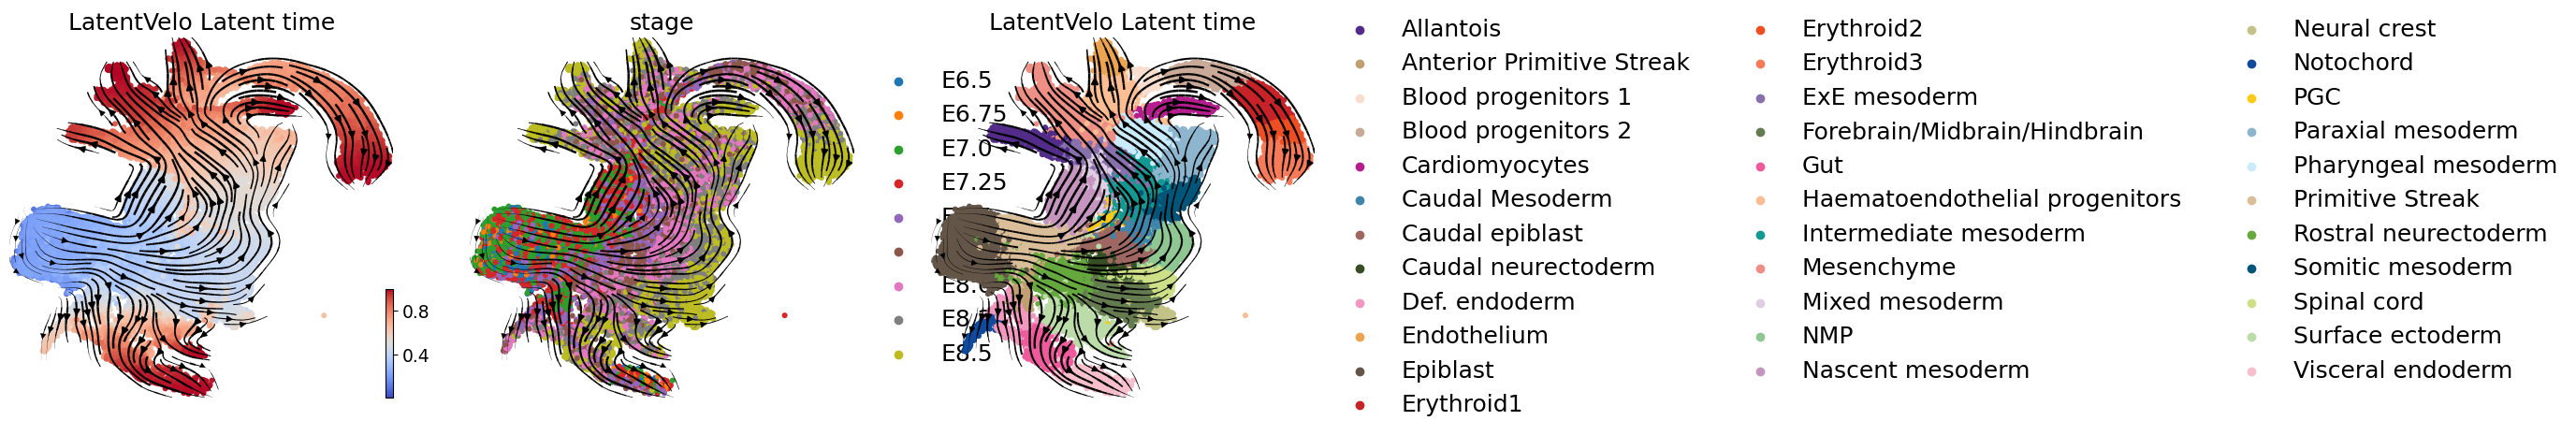

In [12]:
scv.pl.velocity_embedding_stream(latent_adata, basis='umap',vkey='spliced_velocity',
                                 color=['latent_time', 'stage','celltype_names'], color_map='coolwarm',
                                 title=['LatentVelo Latent time', 'stage'], cutoff_perc=0,
                                 alpha=1, legend_fontsize=18, legend_fontoutline=3, fontsize=18,
                                figsize=(6,5), size=75, legend_loc='right')

saving figure to file figures/Mouse_gastrulation_umap_batches.png


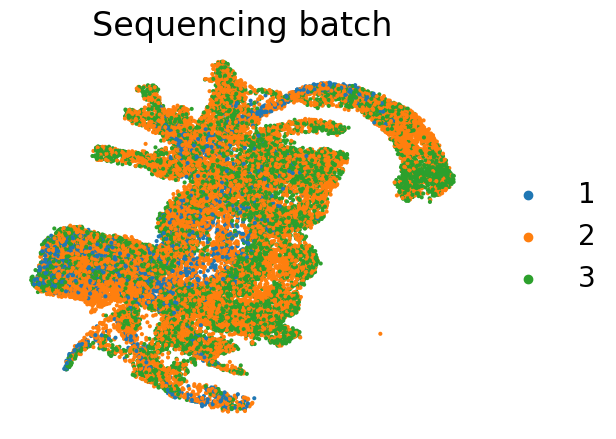

In [13]:
scv.pl.umap(latent_adata, color=['sequencing.batch'], 
            title=['Sequencing batch'], 
            alpha=1, legend_fontsize=20, legend_fontoutline=3, fontsize=24, 
                                figsize=(6,5), size=35, legend_loc='right',
           save='figures/Mouse_gastrulation_umap_batches.png')

In [14]:
latent_adata.obsm['X_umap'] = adata.obsm['X_umap'] #.values

saving figure to file ../figures/Mouse_gastrulation_novelocity.png


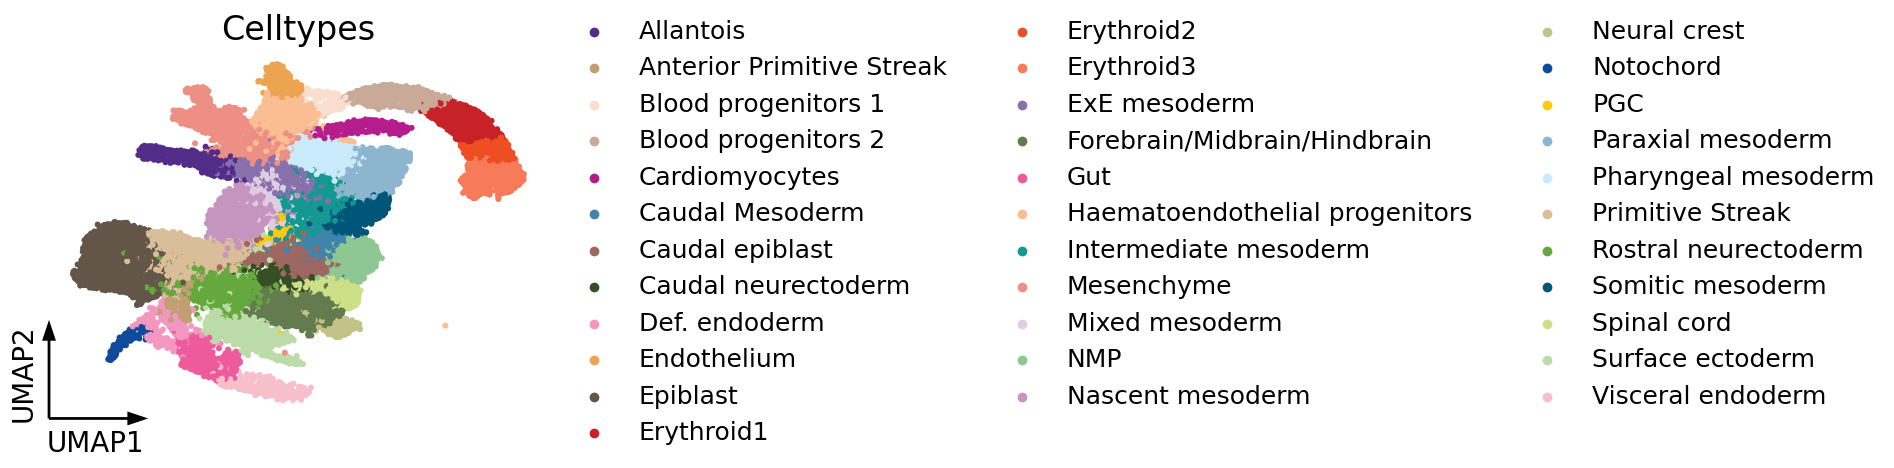

In [15]:
scv.pl.umap(latent_adata, 
                                 color=['celltype_names'], color_map='coolwarm',
                                 title=['Celltypes'], frameon='artist',
                                 alpha=1, legend_fontsize=18, legend_fontoutline=3, fontsize=24,
                                size=75, legend_loc='right', save='../figures/Mouse_gastrulation_novelocity.png')

saving figure to file ../figures/gastrulation_velocity_times.png


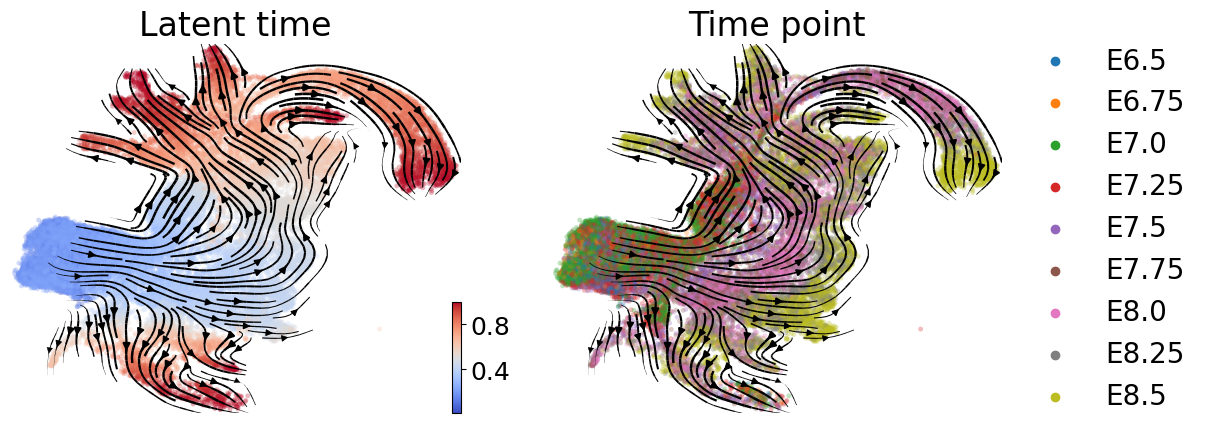

In [16]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['latent_time','stage'], title=['Latent time', 'Time point']
                                 , color_map='coolwarm', size=50, legend_loc='right',
                                 legend_fontsize=20, legend_fontoutline=3, fontsize=24,
                                save='../figures/gastrulation_velocity_times.png')

In [17]:
latent_adata.obsm['X_latent'] = latent_adata.X.copy()

In [18]:
metrics_unint = ltv.ev.integration_metrics(latent_adata, 
                                              label_key='celltype_names', 
                                         batch_key = 'sequencing.batch', 
                                     emb_key='X_pca')
del metrics_unint['iLISI']
    
nn_velo_metics = ltv.ev.nn_velo(latent_adata, layer=True, batch_key='sequencing.batch',
        vkey='spliced_velocity')

metrics_unint['NN velocity'] =  [np.nan]


computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activat

In [19]:
metrics = ltv.ev.integration_metrics(latent_adata, 
                                              label_key='celltype_names', 
                                         batch_key = 'sequencing.batch', 
                                     emb_key='X_latent')
del metrics['iLISI']

nn_velo_metics = ltv.ev.nn_velo(latent_adata, layer=True, batch_key='sequencing.batch',
        vkey='spliced_velocity')

metrics['NN velocity'] =  [nn_velo_metics[0]]


/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (4592×4592).

These matrices should now be stored in the .obsp attribute.
This sl

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/a

Adding diffusion to step 4
Adding diffusion to step 5


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/a

Adding diffusion to step 4
Adding diffusion to step 5


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (385×385).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (385×385).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/h

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (1641×1641).

These matrices should now be stored in the .obsp attribute.
This sl

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/a

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (909×909).

These matrices should now be stored in the .obsp attribute.
This slic

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (345×345).

These matrices should now be stored in the .obsp attribute.
This slic

Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/a

Adding diffusion to step 4
Adding diffusion to step 5


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/a

Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/a

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (1004×1004).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (1004×1004).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


Adding diffusion to step 4
Adding diffusion to step 5


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/a

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


In [20]:
metrics, metrics_unint

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


({'cLISI': [0.9947174435794351],
  'kBET': [0.48184069085764436],
  'NN velocity': [0.97470844]},
 {'cLISI': [0.9893295684466302],
  'kBET': [0.14063756645776937],
  'NN velocity': [nan]})

/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/plotting/metrics.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


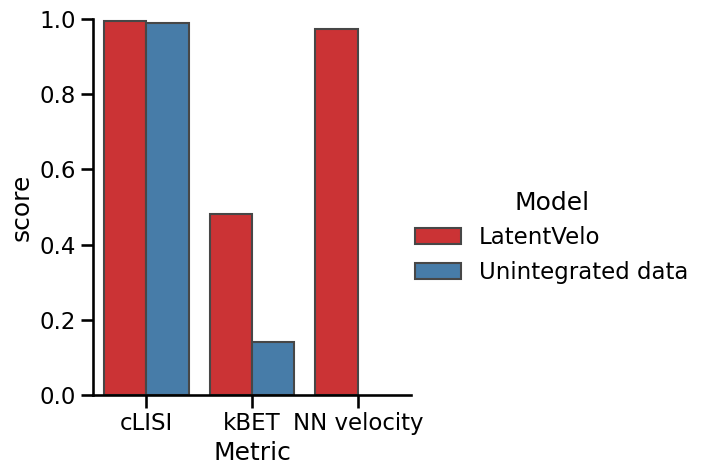

In [21]:
import matplotlib.pyplot as plt
ltv.pl.integration_metrics([metrics, metrics_unint],
                           ['LatentVelo', 'Unintegrated data'],
                           edgecolor='#474747ff',height=5, aspect=1)
#plt.savefig('figures/integration_metrics_2bifurcation.pdf')
plt.show()

In [22]:
adata_scvi = sc.read('data/gastrulation_scvi_batch_correction.h5ad')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
latent_adata.obsm['X_scVI'] = adata_scvi.obsm['X_scVI']
latent_adata.obsm['X_scANVI'] = adata_scvi.obsm['X_scANVI']

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
adata.obs['celltype_names'] = latent_adata.obs.celltype_names.copy()
adata.obs['sequencing.batch'] = latent_adata.obs['sequencing.batch'].copy()

In [25]:
metrics_scvi = ltv.ev.integration_metrics(latent_adata, label_key='celltype_names', 
                                         batch_key = 'sequencing.batch', 
                                          emb_key='X_scVI')

metrics_scanvi = ltv.ev.integration_metrics(latent_adata, label_key='celltype_names', 
                                         batch_key = 'sequencing.batch', 
                                     emb_key='X_scANVI')
del metrics_scvi['iLISI']
del metrics_scanvi['iLISI']

metrics_scvi['NN velocity'] =  [np.nan]
metrics_scanvi['NN velocity'] =  [np.nan]



computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activat

Adding diffusion to step 4
Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (1641×1641).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (1641×1641).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() 

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (287×287).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (287×287).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/h

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/a

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activat

/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (30000×30000).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


Adding diffusion to step 4
Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (303×303).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (303×303).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/h

In [26]:
metrics, metrics_scvi, metrics_scanvi, metrics_unint

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


({'cLISI': [0.9947174435794351],
  'kBET': [0.48184069085764436],
  'NN velocity': [0.97470844]},
 {'cLISI': [0.9730589983242358],
  'kBET': [0.3332126116216333],
  'NN velocity': [nan]},
 {'cLISI': [0.9861681191873949],
  'kBET': [0.30326674574386536],
  'NN velocity': [nan]},
 {'cLISI': [0.9893295684466302],
  'kBET': [0.14063756645776937],
  'NN velocity': [nan]})

/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/plotting/metrics.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


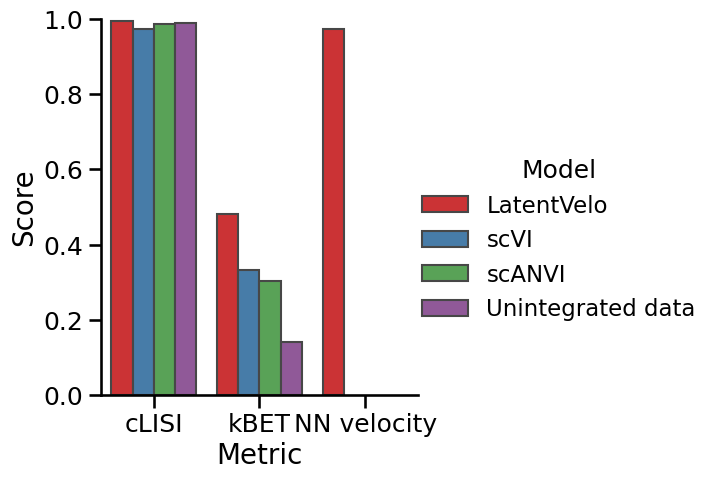

In [27]:
import matplotlib.pyplot as plt

ltv.pl.integration_metrics([metrics, metrics_scvi, metrics_scanvi,
                            metrics_unint],
                           ['LatentVelo', 'scVI', 'scANVI', 'Unintegrated data'],
                           edgecolor='#474747ff',height=5, aspect=1)
plt.xlabel('Metric', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig('figures/integration_metrics_gastrulation_May12.pdf')
plt.show()

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


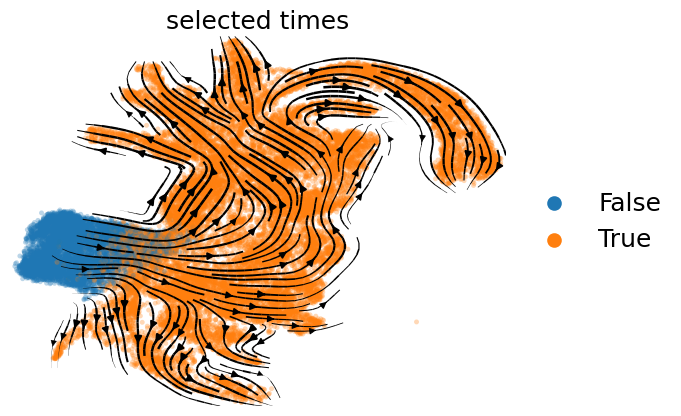

In [28]:
latent_adata.obs['selected_times'] = latent_adata.obs.latent_time > 0.25
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['selected_times']
                                 , color_map='coolwarm', size=50, legend_loc='right',
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


saving figure to file ../figures/gastrulation_velocity_times.png


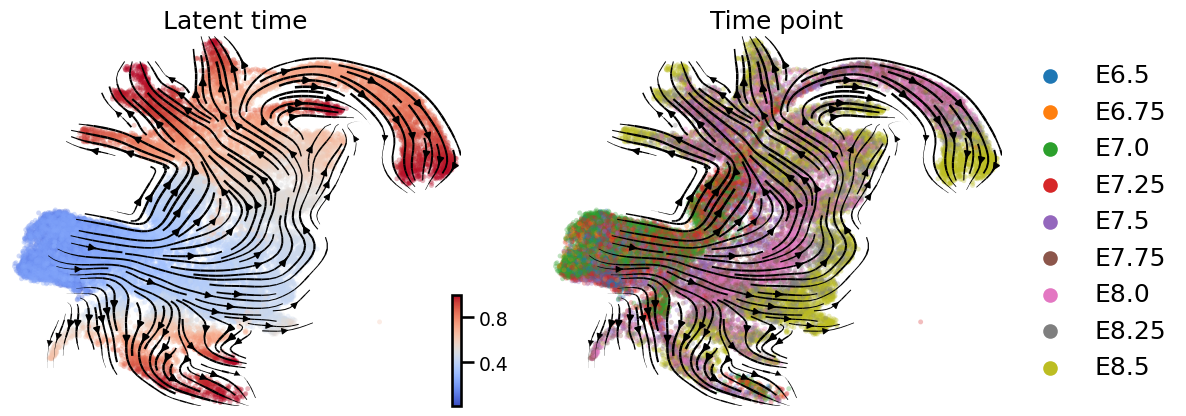

In [29]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['latent_time','stage'], title=['Latent time', 'Time point']
                                 , color_map='coolwarm', size=50, legend_loc='right',
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18,
                                save='../figures/gastrulation_velocity_times.png')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


saving figure to file ../figures/gastrulation_zr.png


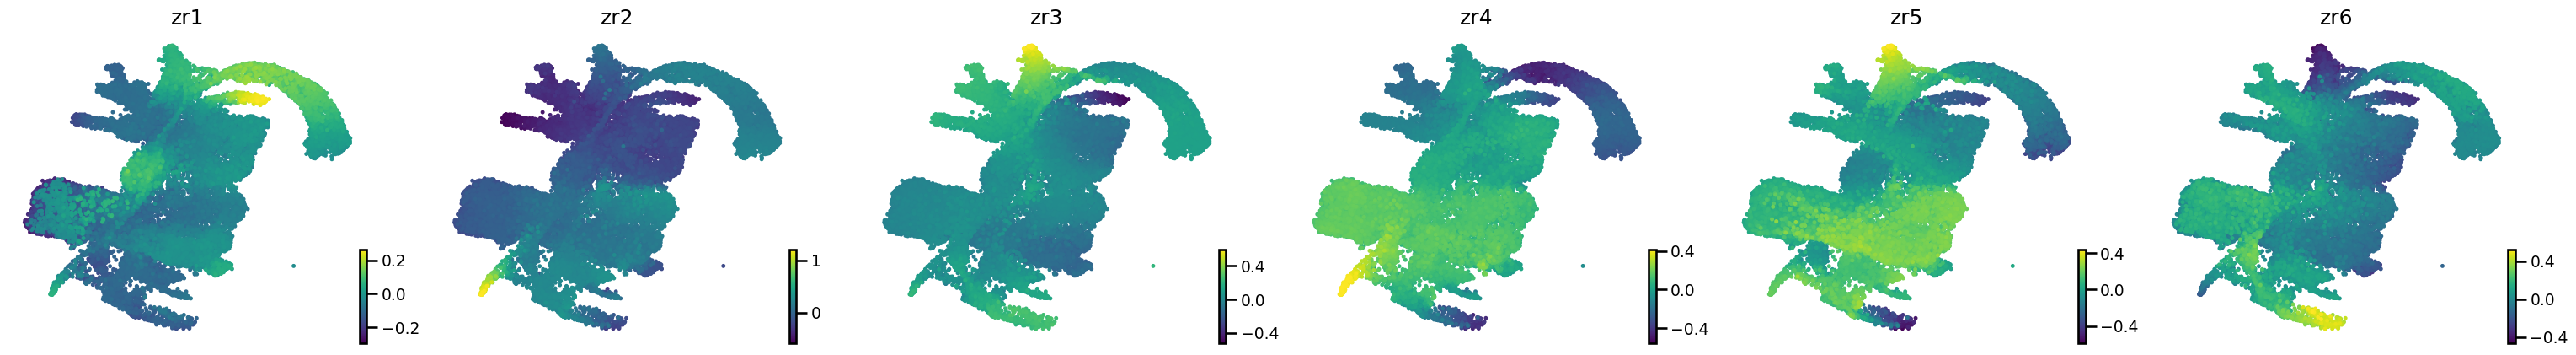

In [30]:
for i in range(latent_adata.obsm['zr'].shape[1]):
    latent_adata.obs['zr'+str(i+1)] = latent_adata.obsm['zr'][:,i].copy()
    
scv.pl.umap(latent_adata, color=['zr1','zr2','zr3','zr4', 'zr5', 'zr6'], size=50,
           save='../figures/gastrulation_zr.png', legend_fontsize=18, legend_fontoutline=3, fontsize=18)

In [31]:
remap_cat_dict = {'Primitive Streak':'Prim. Streak',
                  'Anterior Primitive Streak':'Ant. Prim. Streak',
    'Nascent mesoderm': 'Nasc. mesoderm', 
                   'Haematoendothelial progenitors': 'Haem. endothel. prog.', 
                   'Blood progenitors 1': 'Blood prog. 1', 
                'Blood progenitors 2': 'Blood prog. 2'}

latent_adata.obs['new_celltypes'] = latent_adata.obs['celltype_names'].replace(remap_cat_dict).astype('category') #.map(remap_cat_dict).astype('category')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
import pandas as pd
def transition_scores(transition_scores_raw, model_names=None, model_label = 'Model', 
                      raw=False, custom_colors = None, height=4, aspect=1,ax=None):

    if model_names == None:

        if raw == False:
            
            print('a')
        else:
            score = []
            transition = []
            embedding=[]
            
            for key in transition_scores_raw.keys():
                for item in transition_scores_raw[key]:
                    score.append(item)
                    transition.append(key[0] + r'$\rightarrow$' + key[1])
            
            transition_scores_ = pd.DataFrame({'CBDir score':score, ' ':transition})
            
            PROPS = {
            'boxprops':{'facecolor':'darkgrey', 'edgecolor':'black'},
            'medianprops':{'color':'black'},
            'whiskerprops':{'color':'black'},
                'capprops':{'color':'black'}
            }
            
            ax = sns.boxplot(
                data=transition_scores_, 
                y=' ', x="CBDir score", 
                orient='h', fliersize=0, **PROPS, showmeans=True,ax=ax,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"}
            )

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/evaluation/metrics.py:176: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x_emb == "X_umap":
/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/evaluation/metrics.py:176: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x_emb == "X_umap":
/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/evaluation/metrics.py:176: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x_emb == "X_umap":
<ipython-input-33-14d26ccf0794>:53: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-33-14d26ccf0794>:56: UserWarning: Matplotlib is 

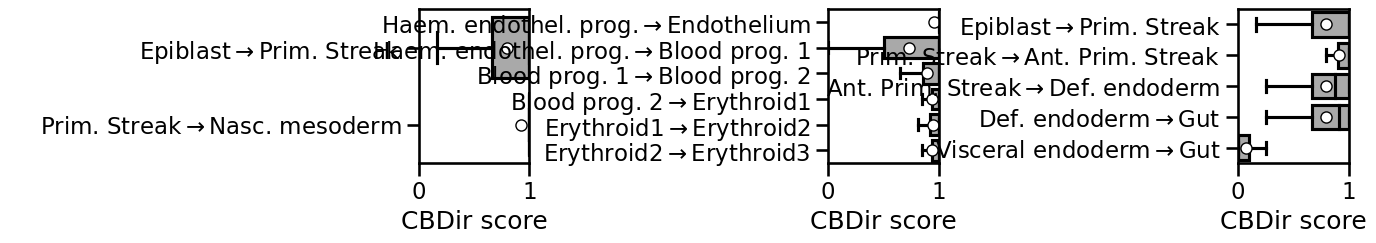

In [33]:
mesoderm_edges = [('Epiblast', 'Prim. Streak'),
                 ('Prim. Streak', 'Nasc. mesoderm')]

latent_adata.obsm['X_latent'] = latent_adata.X.copy()
latent_adata.obsm['velocity_latent'] = latent_adata.layers['spliced_velocity'].copy()

mesoderm_scores = ltv.ev.cross_boundary_correctness(latent_adata, 'new_celltypes', 'velocity_latent', mesoderm_edges,
                                  x_emb='X_latent', majority_vote=True, return_raw=True)

blood_edges = [
                 ('Haem. endothel. prog.', 'Endothelium'),
              ('Haem. endothel. prog.', 'Blood prog. 1'),
              ('Blood prog. 1', 'Blood prog. 2'),
              ('Blood prog. 2', 'Erythroid1'),
              ('Erythroid1', 'Erythroid2'),
              ('Erythroid2', 'Erythroid3')]

latent_adata.obsm['X_latent'] = latent_adata.X.copy()
latent_adata.obsm['velocity_latent'] = latent_adata.layers['spliced_velocity'].copy()

blood_scores = ltv.ev.cross_boundary_correctness(latent_adata, 'new_celltypes', 'velocity_latent', blood_edges,
                                  x_emb='X_latent', majority_vote=True, return_raw=True)

gut_edges = [('Epiblast', 'Prim. Streak'), 
            ('Prim. Streak', 'Ant. Prim. Streak'),
             ('Ant. Prim. Streak', 'Def. endoderm'),
    ('Def. endoderm', 'Gut') ,('Visceral endoderm', 'Gut')]

latent_adata.obsm['X_latent'] = latent_adata.X.copy()
latent_adata.obsm['velocity_latent'] = latent_adata.layers['spliced_velocity'].copy()

gut_scores = ltv.ev.cross_boundary_correctness(latent_adata, 'new_celltypes', 'velocity_latent', gut_edges,
                                  x_emb='X_latent', majority_vote=True, return_raw=True)


import matplotlib.pyplot as plt
import seaborn as sns

fig,ax=plt.subplots(1,3,figsize=(12,2))

transition_scores(mesoderm_scores, raw=True,ax=ax[0])
ax[0].set(xlim=(0.,1))
ax[0].tick_params(axis='y')

transition_scores(blood_scores, raw=True,ax=ax[1])
ax[1].set(xlim=(0.,1))
ax[1].tick_params(axis='y')

transition_scores(gut_scores, raw=True,ax=ax[2])
ax[2].set(xlim=(0.,1))
ax[2].tick_params(axis='y')

fig.tight_layout()
fig.subplots_adjust(wspace=2.7)
#fig.savefig('../figures/gastrulation_transition_scores_May12.pdf')
fig.show()
plt.show()

In [34]:
# free up some space
del adata.layers['Mu']
del adata.layers['Ms']
del adata.layers['spliced_counts']
del adata.layers['unspliced_counts']
del adata.layers['mask_spliced']
del adata.layers['mask_unspliced']

gc.collect()

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


72985

In [35]:
gc.collect()

0

# Trajectories

In [36]:
z_traj, times = ltv.cell_trajectories(model, adata)

/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/output_results.py:319: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (th.Tensor(adata.obs['batch_id'][:,None]).cuda(),


In [37]:
gc.collect()

0

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

pca = PCA(n_components=6).fit(latent_adata.X)
gc.collect()
umap = UMAP(n_components=2, min_dist=0.5, n_neighbors=100).fit(pca.transform(latent_adata.X))

transformed = umap.transform(pca.transform(latent_adata.X))
latent_adata.obsm['X_umap_latent'] = transformed
gc.collect()
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
gc.collect()
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/30000 [00:00<?, ?cells/s]

In [ ]:
gc.collect()

In [ ]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 basis='umap_latent', color=['sequencing.batch', 'celltype_names'], alpha=1, size=50,
                                frameon='artist', legend_loc='right',cutoff_perc=0,
                                xlabel = 'Latent UMAP1', ylabel='Latent UMAP2', title='', legend_fontsize=16,
                                fontsize=15.5)#,
#                                save='../figures/mouse_gastrulation_latent_umap_batch.png')

# Trajectories

In [17]:
ery_cells = np.where(latent_adata.obs.celltype_names.isin(['Erythroid2', 'Erythroid3', 'Erythroid1']))[0]
mese_cells = np.where(latent_adata.obs.celltype_names=='Mesenchyme')[0] 
endothe_cells = np.where(latent_adata.obs.celltype_names=='Endothelium')[0] 
gut_cells = np.where(latent_adata.obs.celltype_names=='Gut')[0]
Allantois_cells = np.where(latent_adata.obs.celltype_names=='Allantois')[0] 
brain_cells = np.where(latent_adata.obs.celltype_names.isin(['Forebrain/Midbrain/Hindbrain',
                                                            'Spinal cord']))[0]
notochord_cells = np.where(latent_adata.obs.celltype_names.isin(['Notochord']))[0]
surface_cells = np.where(latent_adata.obs.celltype_names.isin(['Surface ectoderm']))[0]


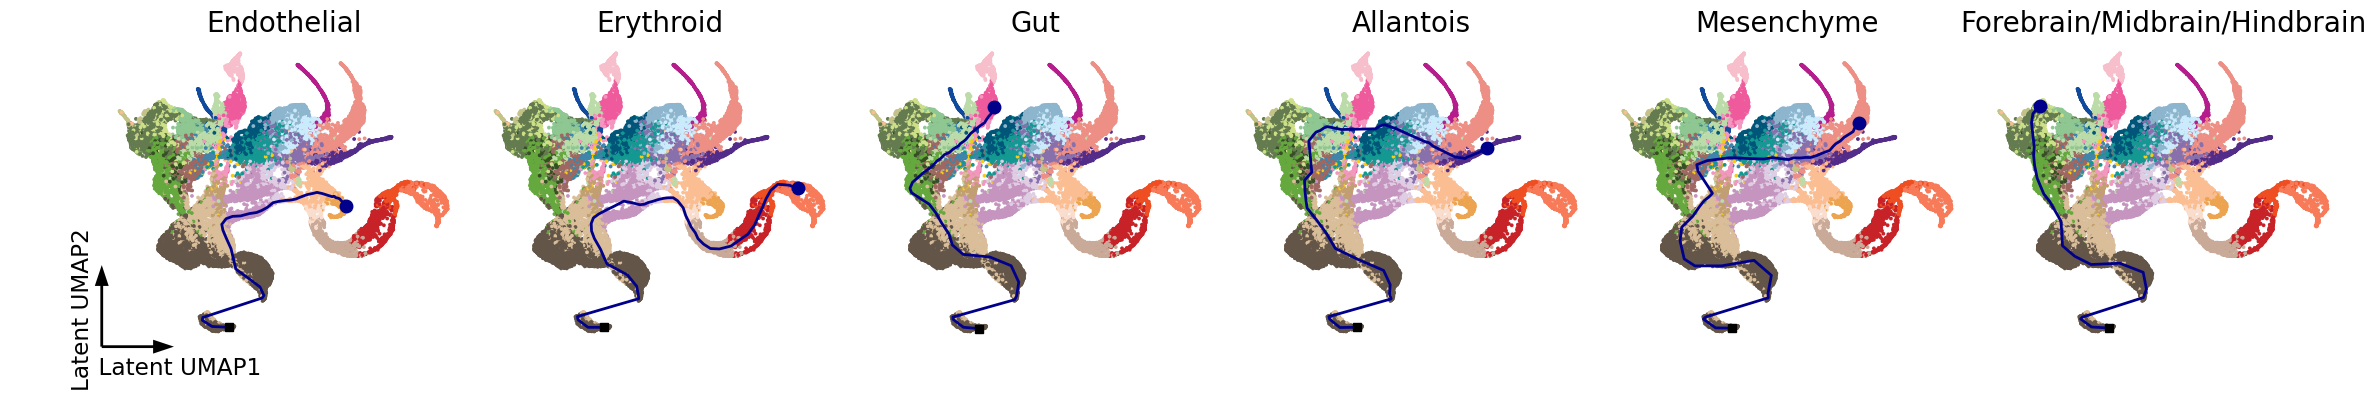

In [48]:
cells = [123, 58, 1, 44, 14, 30] #84 26855
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
color = '#00008B'

import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['#1f78b4', '#b2df8a', '#6a3d9a', '#cab2d6'])


fig,ax=plt.subplots(1, 6, figsize=(23,4))
ax=ax.flatten()


color = '#00008B'

latent_adata.obsm['X_umap'] = latent_adata.obsm['X_umap_latent']

z_traj_pca = umap.transform(pca.transform(z_traj[cells[0],times[cells[0],:,0]<=latent_adata.obs['latent_time'][cells[0]],:70].detach().cpu().numpy()))
ax[0].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[0].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[0].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[0], color='celltype_names', frameon='artist',
           xlabel='            Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=20, title='Endothelial', legend_loc='none',size=30)


z_traj_pca = umap.transform(pca.transform(z_traj[cells[1],times[cells[1],:,0]<=latent_adata.obs['latent_time'][cells[1]],:70].detach().cpu().numpy()))
ax[1].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[1].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[1].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[1], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=20, title='Erythroid', legend_loc='none',size=30)


z_traj_pca = umap.transform(pca.transform(z_traj[cells[2],times[cells[2],:,0]<=latent_adata.obs['latent_time'][cells[2]],:70].detach().cpu().numpy()))
ax[2].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[2].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[2].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[2], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', fontsize=20, show=False, title='Gut', legend_loc='none',size=30)


z_traj_pca = umap.transform(pca.transform(z_traj[cells[3],times[cells[3],:,0]<=latent_adata.obs['latent_time'][cells[3]],:70].detach().cpu().numpy()))
ax[3].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[3].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[3].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[3], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=20, title='Allantois', legend_loc='none',size=30)



z_traj_pca = umap.transform(pca.transform(z_traj[cells[4],times[cells[4],:,0]<=latent_adata.obs['latent_time'][cells[4]],:70].detach().cpu().numpy()))
ax[4].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[4].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[4].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[4], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=20, title='Mesenchyme', legend_loc='none',size=30)


z_traj_pca = umap.transform(pca.transform(z_traj[cells[5],times[cells[5],:,0]<=latent_adata.obs['latent_time'][cells[5]],:70].detach().cpu().numpy()))
ax[5].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[5].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[5].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[5], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=20, title='Forebrain/Midbrain/Hindbrain', 
            legend_loc='none', legend_fontsize=20,size=30)

plt.tight_layout()
plt.savefig('../figures/Mouse_gastrulation_trajectories_May21.png', dpi=500)
plt.show()

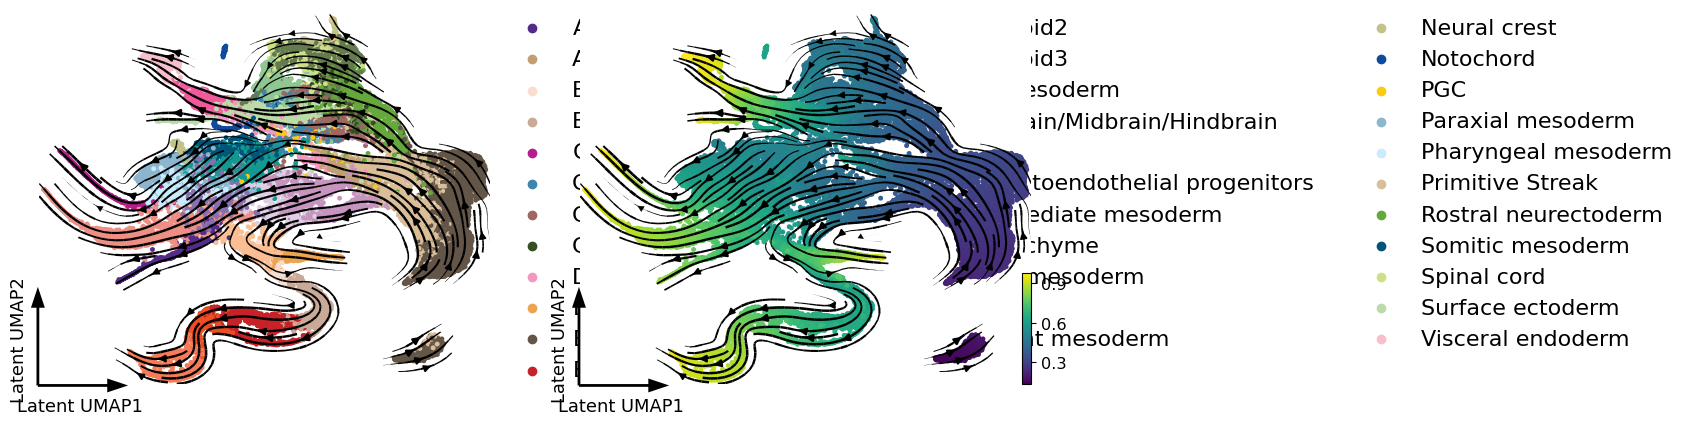

In [32]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 basis='umap_latent', color=['celltype_names', 'latent_time'], alpha=1, size=50,
                                frameon='artist', legend_loc='right',cutoff_perc=0,
                                xlabel = 'Latent UMAP1', ylabel='Latent UMAP2', title='', legend_fontsize=16,
                                fontsize=15.5)#,
                                #save='../figures/mouse_gastrulation_latent_umap.png')

In [18]:
np.random.seed(123)

ery_cells = ery_cells[np.random.choice(len(ery_cells), size=100, replace=False)]
mese_cells = mese_cells[np.random.choice(len(mese_cells), size=100, replace=False)]
endothe_cells = endothe_cells[np.random.choice(len(endothe_cells), size=100, replace=False)]
gut_cells = gut_cells[np.random.choice(len(gut_cells), size=100, replace=False)]
Allantois_cells = Allantois_cells[np.random.choice(len(Allantois_cells), size=100, replace=False)]
brain_cells = brain_cells[np.random.choice(len(brain_cells), size=100, replace=False)]
notochord_cells = notochord_cells[np.random.choice(len(notochord_cells), size=100, replace=False)]
surface_cells = surface_cells[np.random.choice(len(surface_cells), size=100, replace=False)]

In [20]:
with th.no_grad():
    xhat_ery  = ltv.tl.cell_trajectories(z_traj[ery_cells], times[ery_cells], latent_adata, adata, ery_cells, 0.25)
    xhat_mese = ltv.tl.cell_trajectories(z_traj[mese_cells], times[mese_cells], latent_adata, adata, mese_cells, 0.25)
    xhat_endothe = ltv.tl.cell_trajectories(z_traj[endothe_cells], times[endothe_cells], latent_adata, adata, endothe_cells, 0.25)
    xhat_gut = ltv.tl.cell_trajectories(z_traj[gut_cells], times[gut_cells], latent_adata, adata, gut_cells, 0.25)
    xhat_Allantois = ltv.tl.cell_trajectories(z_traj[Allantois_cells], times[Allantois_cells], latent_adata, adata, Allantois_cells, 0.25)
    xhat_brain = ltv.tl.cell_trajectories(z_traj[brain_cells], times[brain_cells], latent_adata, adata, brain_cells, 0.25)
    xhat_notochord = ltv.tl.cell_trajectories(z_traj[notochord_cells], times[notochord_cells], latent_adata, adata, notochord_cells, 0.25)
    xhat_surface = ltv.tl.cell_trajectories(z_traj[surface_cells], times[surface_cells], latent_adata, adata, surface_cells, 0.25)

In [22]:
import pandas as pd

ery_df = pd.DataFrame(xhat_ery, columns=adata.var.index.values)
ery_df['clusters'] = 'Erythroid'

mese_df = pd.DataFrame(xhat_mese, columns=adata.var.index.values)
mese_df['clusters'] = 'Mesenchyme'

endothe_df = pd.DataFrame(xhat_endothe, columns=adata.var.index.values)
endothe_df['clusters'] = 'Endothelium'

gut_df = pd.DataFrame(xhat_gut, columns=adata.var.index.values)
gut_df['clusters'] = 'Gut'

Allantois_df = pd.DataFrame(xhat_Allantois, columns=adata.var.index.values)
Allantois_df['clusters'] = 'Allantois'

brain_df = pd.DataFrame(xhat_brain, columns=adata.var.index.values)
brain_df['clusters'] = 'Brain'

notochord_df = pd.DataFrame(xhat_notochord, columns=adata.var.index.values)
notochord_df['clusters'] = 'Notochord'

surface_df = pd.DataFrame(xhat_surface, columns=adata.var.index.values)
surface_df['clusters'] = 'Surface ectoderm'

df = pd.concat([ery_df, mese_df, endothe_df, gut_df, Allantois_df, brain_df, notochord_df, surface_df])

In [25]:
ery_de = ltv.tl.de_genes(adata, df, 'Erythroid', celltype_key='clusters', mode='greater')

In [26]:
ery_de['statistic'] = -1*np.abs(ery_de['statistic'])
ery_de = ery_de.sort_values('statistic')

In [27]:
ery_de_genes = list(ery_de[ery_de['pval'] < 1e-5][:250]['gene'].values)

In [28]:
import gseapy

enr_res = gseapy.enrichr(gene_list=ery_de_genes,
                     organism='mouse', 
                         background=list(adata.var.index.values),
                     gene_sets=['GO_Biological_Process_2021'])

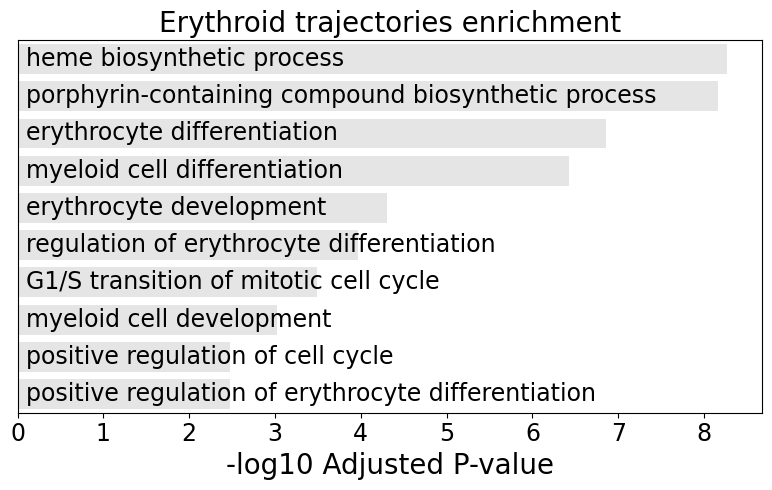

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(8,5))

enr_res.results.Term = enr_res.results.Term.str.split(" \(GO").str[0]

results_df = enr_res.results
results_df = results_df[results_df['Adjusted P-value'] < 0.05]
results_df['-log10 Adjusted P-value'] = -1*np.log10(results_df['Adjusted P-value'])

ax=sns.barplot(data = results_df[:10], x='-log10 Adjusted P-value', y='Term', color='grey',
              alpha=0.2)

ax.set_yticks([])
ax.set_yticklabels([]) 
ax.set_ylabel('')
ax.set_xlabel('-log10 Adjusted P-value', fontsize=20)
ax.tick_params(labelsize=17)

plt.title('Erythroid trajectories enrichment', fontsize=20)

for i, yi in enumerate(np.arange(min(results_df.shape[0],10))):
    ax.text(0.1, yi, results_df['Term'][i], horizontalalignment='left', verticalalignment='center',
           fontsize=17)
plt.tight_layout()
#plt.savefig('figures/Gastrulation_Erythroid_trajectories_GO_May21.pdf')
plt.show()

In [32]:
endo_de = ltv.tl.de_genes(adata, df, 'Endothelium', celltype_key='clusters', mode='greater')

In [33]:
endo_de['statistic'] = -1*np.abs(endo_de['statistic'])
endo_de = endo_de.sort_values('statistic')

In [34]:
endo_de_genes = list(endo_de[endo_de['pval'] < 1e-5][:250]['gene'].values)

In [35]:
import gseapy

enr_res = gseapy.enrichr(gene_list=endo_de_genes,
                     organism='mouse', 
                     background=list(adata.var.index.values),
                     gene_sets=['GO_Biological_Process_2021'])

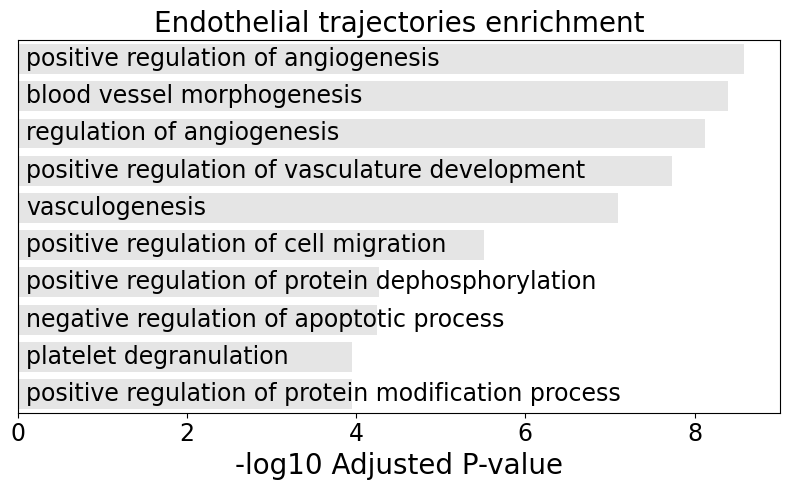

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(8,5))

enr_res.results.Term = enr_res.results.Term.str.split(" \(GO").str[0]

results_df = enr_res.results
results_df = results_df[results_df['Adjusted P-value'] < 0.05]
results_df['-log10 Adjusted P-value'] = -1*np.log10(results_df['Adjusted P-value'])

ax=sns.barplot(data = results_df[:10],x='-log10 Adjusted P-value', y='Term', color='grey',
              alpha=0.2)

ax.set_yticks([])
ax.set_yticklabels([]) 
ax.set_ylabel('')
ax.set_xlabel('-log10 Adjusted P-value', fontsize=20)
ax.tick_params(labelsize=17)

plt.title('Endothelial trajectories enrichment', fontsize=20)

for i, yi in enumerate(np.arange(min(results_df.shape[0],10))):
    ax.text(0.1, yi, results_df['Term'][i], horizontalalignment='left', verticalalignment='center',
           fontsize=17)
plt.tight_layout()
#plt.savefig('figures/Gastrulation_Endothelial_trajectories_GO_May21.pdf')
plt.show()

In [37]:
mese_de = ltv.tl.de_genes(adata, df, 'Mesenchyme', celltype_key='clusters', mode='greater')

In [38]:
mese_de['statistic'] = -1*np.abs(mese_de['statistic'])
mese_de = mese_de.sort_values('statistic')

In [39]:
mese_de_genes = list(mese_de[mese_de['pval'] < 1e-5][:250]['gene'].values)

In [40]:
import gseapy

enr_res = gseapy.enrichr(gene_list=mese_de_genes,
                     organism='mouse', 
                     background=list(adata.var.index.values),
                     gene_sets=['GO_Biological_Process_2021'])

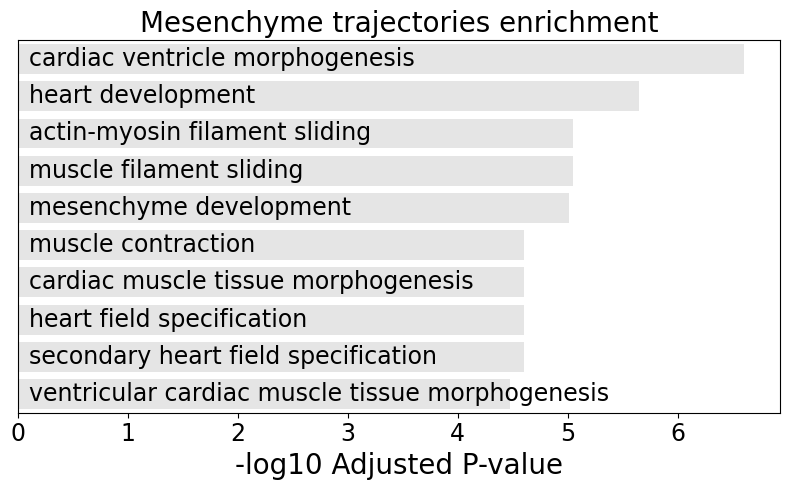

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(8,5))

enr_res.results.Term = enr_res.results.Term.str.split(" \(GO").str[0]

results_df = enr_res.results
results_df = results_df[results_df['Adjusted P-value'] < 0.05]
results_df['-log10 Adjusted P-value'] = -1*np.log10(results_df['Adjusted P-value'])

ax=sns.barplot(data = results_df[:10], x='-log10 Adjusted P-value', y='Term', color='grey',
              alpha=0.2)

ax.set_yticks([])
ax.set_yticklabels([]) 
ax.set_ylabel('')
ax.set_xlabel('-log10 Adjusted P-value', fontsize=20)
ax.tick_params(labelsize=17)

plt.title('Mesenchyme trajectories enrichment', fontsize=20)

for i, yi in enumerate(np.arange(min(results_df.shape[0],10))):
    ax.text(0.1, yi, results_df['Term'][i], horizontalalignment='left', verticalalignment='center',
           fontsize=17)
plt.tight_layout()
#plt.savefig('figures/Gastrulation_Mesenchyme_trajectories_GO_May21.pdf')
plt.show()

In [42]:
brain_de = ltv.tl.de_genes(adata, df, 'Brain', celltype_key='clusters', mode='greater')

In [43]:
brain_de['statistic'] = -1*np.abs(brain_de['statistic'])
brain_de = brain_de.sort_values('statistic')

In [44]:
brain_de_genes = list(brain_de[brain_de['pval'] < 1e-5][:250]['gene'].values)

In [45]:
import gseapy

enr_res = gseapy.enrichr(gene_list=brain_de_genes,
                     organism='mouse', 
                     background=list(adata.var.index.values),
                     gene_sets=['GO_Biological_Process_2021'])

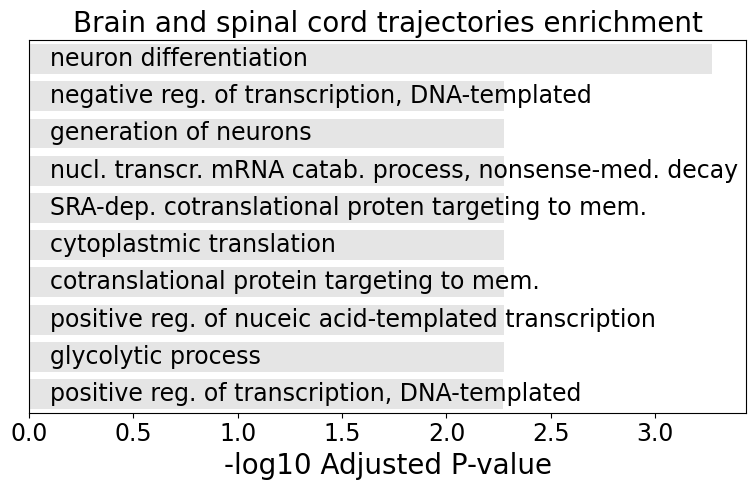

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(8.3,5))

enr_res.results.Term = enr_res.results.Term.str.split(" \(GO").str[0]

results_df = enr_res.results
results_df = results_df[results_df['Adjusted P-value'] < 0.05]
results_df['-log10 Adjusted P-value'] = -1*np.log10(results_df['Adjusted P-value'])

ax=sns.barplot(data = results_df[:10], x='-log10 Adjusted P-value', y='Term', color='grey',
              alpha=0.2)

ax.set_yticks([])
ax.set_yticklabels([]) 
ax.set_ylabel('')
ax.set_xlabel('-log10 Adjusted P-value', fontsize=20)
ax.tick_params(labelsize=17)

plt.title('Brain and spinal cord trajectories enrichment', fontsize=20)

terms = ['neuron differentiation','negative reg. of transcription, DNA-templated',
        'generation of neurons', 'nucl. transcr. mRNA catab. process, nonsense-med. decay',
        'SRA-dep. cotranslational proten targeting to mem.',
        'cytoplastmic translation', 'cotranslational protein targeting to mem.',
        'positive reg. of nuceic acid-templated transcription',
        'glycolytic process', 'positive reg. of transcription, DNA-templated']
for i, yi in enumerate(np.arange(min(results_df.shape[0],10))):
    ax.text(0.1, yi, terms[i], horizontalalignment='left', verticalalignment='center',
           fontsize=17)
plt.tight_layout()
plt.savefig('figures/Gastrulation_Brain_trajectories_GO_June2.pdf')
plt.show()